# Correspondence Autoencoder RNN for Speech

Herman Kamper, Stellenbosch University, 2019.

## Preliminaries

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sys.path.append(path.join("..", "src"))
sys.path.append(path.join("..", "embeddings"))

import batching
import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Data

In [4]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye", "devpart1.utd.dd.npz")
)

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 12045
E.g. item shape: (61, 39)


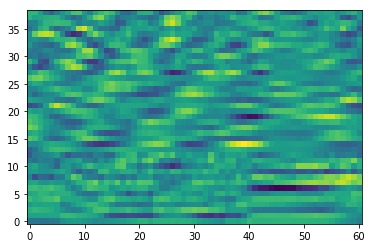

In [5]:
plt.imshow(train_x[3277].T, origin="bottom");

In [6]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye",
    "devpart2.samediff.dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2732
E.g. item shape: (61, 39)


In [7]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

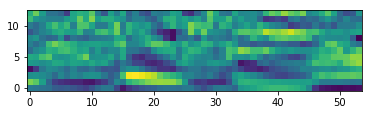

In [15]:
plt.imshow(train_x[3277 + 1].T, origin="bottom");

## Multi-layer RNN-CAE

**Autoencoder pretraining**

In [27]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
ae_n_epochs = 100  # 100
n_val_interval = 1
ae_batch_size = 300
ae_n_buckets = 3
pair_list = batching.get_pair_list(train_labels)

# Model parameters
n_input = d_frame
enc_n_hiddens = [400, 400, 400]
dec_n_hiddens = [400, 400, 400]
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130, # 130,
    "dec_n_hiddens": [dec_n_hiddens[0]],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
pretrain_intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.pretrain.tmp.ckpt")
pretrain_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.pretrain.ckpt")
intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.tmp.ckpt")
model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.ckpt")

# Model
a = tf.placeholder(TF_DTYPE, [None, None, n_input])
a_lengths = tf.placeholder(TF_ITYPE, [None])
b = tf.placeholder(TF_DTYPE, [None, None, n_input])
b_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_multi_encdec_lazydynamic_latentfunc(
    a, a_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, y_lengths=b_lengths, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
ae = network_dict["latent_layer"]
z = ae["z"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

y *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(b - y), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [28]:
def samediff_val(normalise=True):
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = batching.SimpleIterator(val_x, len(val_x), False)
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, val_model_fn)
        for batch_x_padded, batch_x_lengths in val_batch_iterator:
            np_x = batch_x_padded
            np_x_lengths = batch_x_lengths
            np_z = session.run(
                [z], feed_dict={a: np_x, a_lengths: np_x_lengths}
                )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate(
            [val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

    # Same-different
    if normalise:
        np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
        distances = pdist(np_z_normalised, metric="cosine")
        matches = samediff.generate_matches_array(labels)
        ap, prb = samediff.average_precision(
            distances[matches == True], distances[matches == False]
            )
    else:
        distances = pdist(np_z, metric="cosine")
        matches = samediff.generate_matches_array(labels)
        ap, prb = samediff.average_precision(
            distances[matches == True], distances[matches == False]
            )    
    return [prb, -ap]

In [ ]:
# Train AE

np.random.seed(1)

train_batch_iterator = batching.PairedBucketIterator(
    train_x, [(i, i) for i in range(len(train_x))], ae_batch_size, ae_n_buckets, shuffle_every_epoch=True
    )

val_model_fn = pretrain_intermediate_model_fn

ae_record_dict = training.train_fixed_epochs_external_val(
    ae_n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_lengths, b, b_lengths], samediff_val,
    save_model_fn=pretrain_intermediate_model_fn,
    save_best_val_model_fn=pretrain_model_fn,
    n_val_interval=n_val_interval
    )

2019-06-05 14:13:12.066603
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
16.020 sec, train loss: 1.091389, val loss: [0.03170438318384941, -0.010425175301012312] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.462 sec, train loss: 0.85693157, val loss: [0.07640681466184822, -0.027563744163746896] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.030 sec, train loss: 0.8065807, val loss: [0.09241094475993805, -0.042049247460577546] *
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.007 sec, train loss: 0.76447177, val loss: [0.11879269162160519, -0.06136571634669819] *
Epoch 4:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.519 sec, train loss: 0

**Correspondence autoencoder training**

In [ ]:
# Training parameters
learning_rate = 0.001
cae_n_epochs = 20
n_val_interval = 1
cae_batch_size = 300
cae_n_buckets = 3

In [ ]:
# Train CAE
train_batch_iterator = batching.PairedBucketIterator(
    train_x, pair_list, batch_size=cae_batch_size, n_buckets=cae_n_buckets, shuffle_every_epoch=True
    )

cae_pretrain_model_fn = pretrain_model_fn
val_model_fn = intermediate_model_fn

cae_record_dict = training.train_fixed_epochs_external_val(
    cae_n_epochs, optimizer, loss,
    train_batch_iterator, [a, a_lengths, b, b_lengths],
    samediff_val, save_model_fn=intermediate_model_fn,
    save_best_val_model_fn=model_fn,
    n_val_interval=n_val_interval,
    load_model_fn=cae_pretrain_model_fn
    )